### 투표기반 분류기의 성능 확인

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# sklearn ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
import platform
from matplotlib import font_manager, rc
#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name =font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    mpl.rcParams['axes.unicode_minus'] = False
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [4]:
#데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state =42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print(X[0:5])
print(y[0:5])

[[ 0.83103915 -0.25874875]
 [ 1.18506381  0.92038714]
 [ 1.16402213 -0.45552558]
 [-0.0236556   1.08628844]
 [ 0.48050273  1.50942444]]
[1 0 1 0 0]


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [9]:
#각 모델의 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [10]:
#간접 투표 방식
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging을 이용한 앙상블

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print("정확도 : ", accuracy_score(y_test, y_pred))

정확도 :  0.904


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [15]:
#oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_


0.8986666666666666

## 배깅과 랜덤포레스트

In [16]:
#배깅을 이용한 Random Forest
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [17]:
#랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [18]:
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

1.0


In [19]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [21]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [22]:
#결측치 처리
# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)
# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
rdf['embarked'].fillna(most_freq, inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [24]:
# 분석에 활용할 열(속성)을 선택
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

#순서가 없는 범주형 데이터의 원 핫 인코딩
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [26]:
#피처와 타겟을 분리
#독립 변수 X
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']] 
#종속 변수 Y
y=ndf['survived'] 

#정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

[[ 0.91123237 -0.53037664  0.52457013 -0.50589515 -0.75905134  0.75905134
  -0.47180795 -0.20203051  0.53307848]
 [-1.47636364  0.57183099  0.52457013 -0.50589515  1.31743394 -1.31743394
   2.11950647 -0.20203051 -1.87589641]
 [ 0.91123237 -0.25482473 -0.55170307 -0.50589515  1.31743394 -1.31743394
  -0.47180795 -0.20203051  0.53307848]
 [-1.47636364  0.36516706  0.52457013 -0.50589515  1.31743394 -1.31743394
  -0.47180795 -0.20203051  0.53307848]
 [ 0.91123237  0.36516706 -0.55170307 -0.50589515 -0.75905134  0.75905134
  -0.47180795 -0.20203051  0.53307848]]


In [28]:
#훈련 데이터와 테스트 데이터 분할
#데이터가 랜덤하게 배치되어 있다면 분할으 할 때 순서대로 앞에서 일정 부분은
#훈련 데이터로 사용하고 일정 부분은 테스트 데이터로 할당하면 됨

#타겟의 비율을 고려
#타겟의 비율이 고르지 않다면 여러가지 고려
#층화 추출이나 oversampling이나 undersampling
#이상치 탐지에서 이 부분이 항상 고려 대상

#훈련 데이터의 비율 - 일반적으로 0.7이나 0.8을 많이 사용

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [30]:
forest = RandomForestClassifier(criterion='entropy',n_estimators=25,
                                random_state=1,n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=25, n_jobs=-1,
                       random_state=1)

In [31]:
#평가 지표 확인
# test data를 가지고 y_hat을 예측 (분류)
y_hat = forest.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

[1 1 1 1 0 1 0 1 0 1]
[0 1 1 1 0 1 1 1 0 0]




In [32]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics

#오차 행렬 확인
tree_matrix = metrics.confusion_matrix(y_test, y_hat)
print(tree_matrix)


# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

[[104  22]
 [ 26  63]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       126
           1       0.74      0.71      0.72        89

    accuracy                           0.78       215
   macro avg       0.77      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215



(-1.0, 9.0)

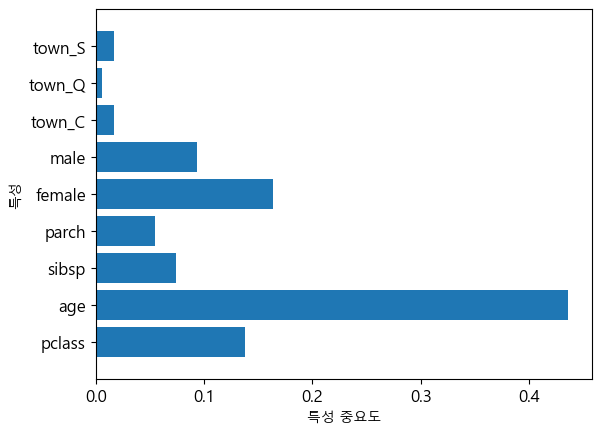

In [33]:
#특성 중요도 확인
n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

## AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier

#algarithm 은 확률을 계산할 수 있으면 SAMME.R이고 없으면 SAMME
#learn_rate 는 학습률
#학습률이 너무 크면 최적화 되지 않을 가능성이 높아지고
#너무 작으면 훈련 속도가 느려져 overfitting 될 가능성이 발생
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train, y_train)

y_hat = ada_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 1 0 0 0 0 1 1]
[0 1 1 1 0 1 1 1 0 0]


In [ ]:
#오차 행렬 확인
tree_matrix = metrics.confusion_matrix(y_test, y_hat)
print(tree_matrix)


# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

In [38]:
%%time
#쥬피터 노트북에서 시간 측정할 때 사용 - 최상단에 위치해야함

#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier


gbm_clf = GradientBoostingClassifier(random_state=42)

gbm_clf.fit(X_train, y_train)

y_hat = gbm_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 1 0 1 0 1 0 1]
[0 1 1 1 0 1 1 1 0 0]
CPU times: total: 0 ns
Wall time: 63.2 ms


In [41]:
#하이퍼 파라미터 튜닝 - 시간이 많을 때는 여러 값을 설정(없을 땐 줄이기)
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]}
grid_cv = GridSearchCV(gbm_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
최고 예측 정확도: 0.8137


In [42]:
#튜닝의 결과로 예측
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.8000
